### Figuras de los resultados de Prokka

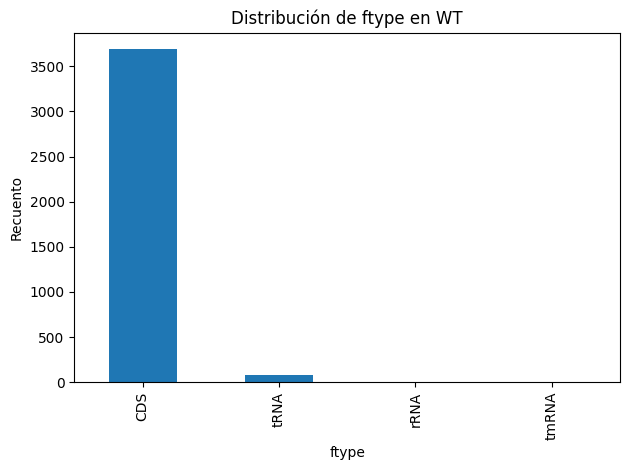

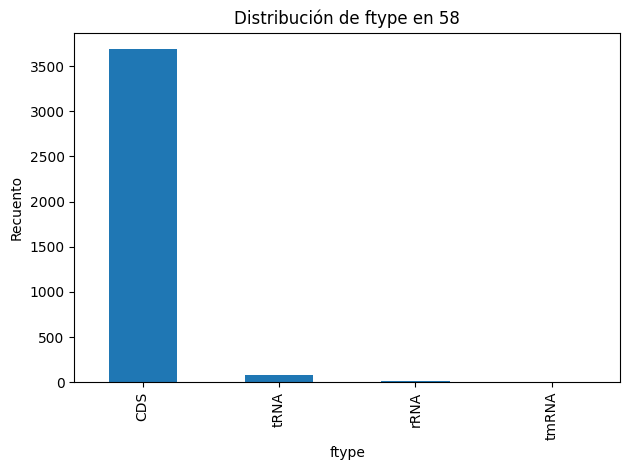

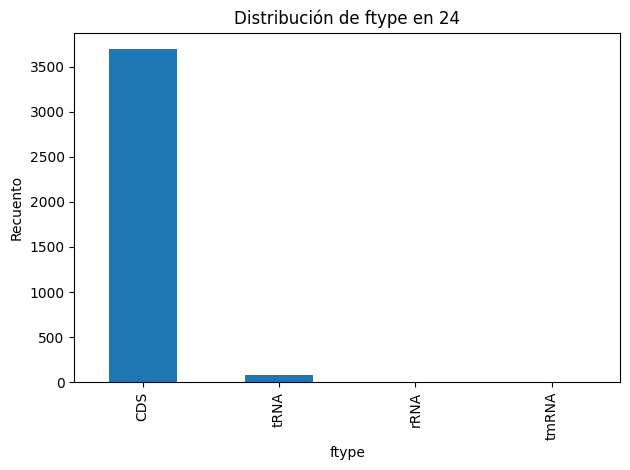

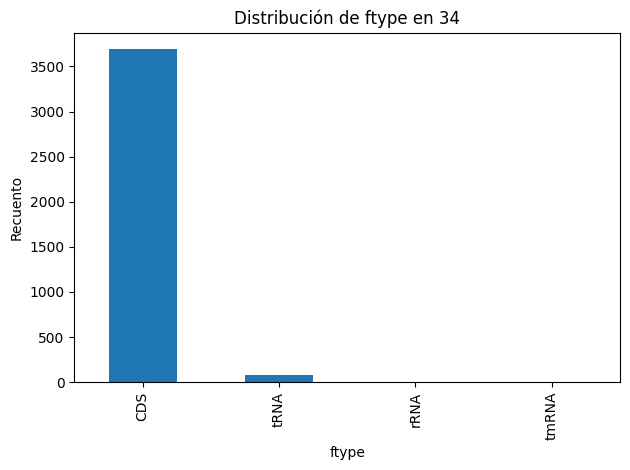

<Figure size 800x500 with 0 Axes>

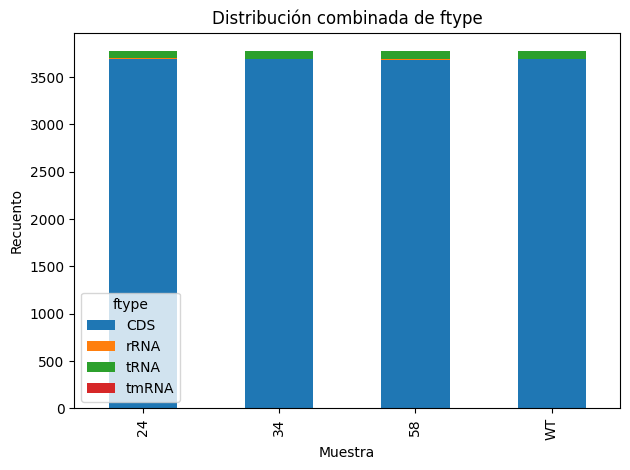

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os

# 1) Encuentra todos los TSV filtrados
files = glob.glob('anotacion/figures/*_filtrado.tsv')
if not files:
    raise FileNotFoundError("No se encontraron archivos '*_filtrado.tsv' en ")

# 2) Carga en un dict de DataFrames
dfs = {}
for fp in files:
    sample = os.path.basename(fp).replace('_filtrado.tsv','')
    df = pd.read_csv(fp, sep='\t')
    dfs[sample] = df

# 3) Columna de "clasificación"
#    Por ejemplo: 'COG' o 'product'
classification_col = 'ftype'

# Verifica que exista en todas las muestras
for sample, df in dfs.items():
    if classification_col not in df.columns:
        raise KeyError(f"La columna '{classification_col}' no está en {sample} (columnas: {list(df.columns)})")

# 4) Grafica cada muestra por separado
for sample, df in dfs.items():
    counts = df[classification_col].value_counts()
    plt.figure()
    counts.plot(kind='bar')
    plt.title(f"Distribución de {classification_col} en {sample}")
    plt.xlabel(classification_col)
    plt.ylabel("Recuento")
    plt.tight_layout()
    plt.show()

# 5) Grafica todas apiladas en un solo plot
combined = pd.concat(
    [df.assign(sample=sample) for sample, df in dfs.items()],
    ignore_index=True
)
counts_combined = combined.groupby(['sample', classification_col]) \
                         .size() \
                         .unstack(fill_value=0)
plt.figure(figsize=(8,5))
counts_combined.plot(kind='bar', stacked=True)
plt.title(f"Distribución combinada de {classification_col}")
plt.xlabel("Muestra")
plt.ylabel("Recuento")
plt.tight_layout()
plt.show()



### Resultados comparativos entre la 24 y WT

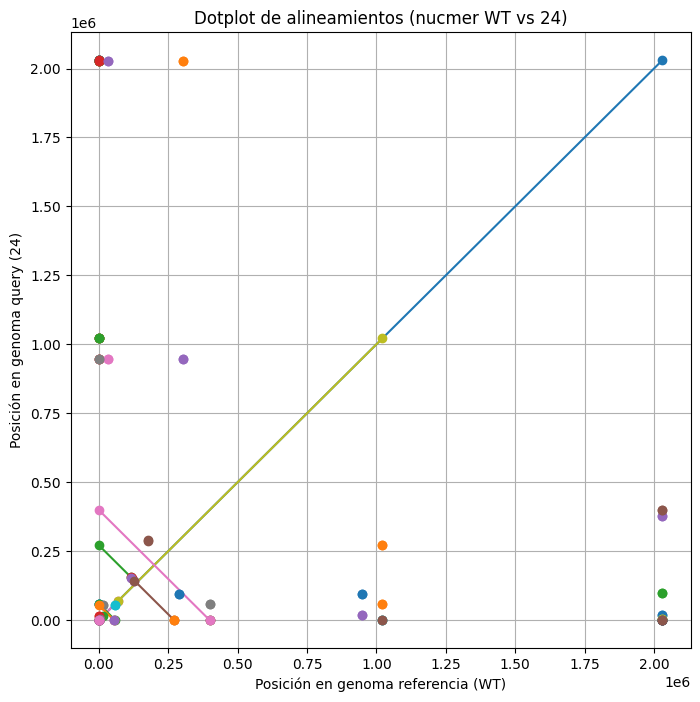

In [27]:
import matplotlib.pyplot as plt
from io import StringIO

# --- Función para parsear archivo .delta y extraer alineamientos ---
def parse_delta(delta_file):
    alignments = []
    with open(delta_file) as f:
        for line in f:
            if line.startswith('>') or line.startswith('#'):
                continue
            line = line.strip()
            if line == '':
                continue
            parts = line.split()
            # Las líneas con 7 números contienen la info de alineamiento
            if len(parts) == 7:
                ref_start, ref_end, query_start, query_end = map(int, parts[0:4])
                alignments.append((ref_start, ref_end, query_start, query_end))
    return alignments


# --- Las rutas a los archivos ---
delta_path = 'anotacion/WT_vs_24.delta'  # archivo .delta de nucmer


# --- Parsear alineamientos ---
alignments = parse_delta(delta_path)

# --- Plot dotplot simple ---
plt.figure(figsize=(8,8))
for ref_start, ref_end, query_start, query_end in alignments:
    plt.plot([ref_start, ref_end], [query_start, query_end], marker='o')
plt.xlabel('Posición en genoma referencia (WT)')
plt.ylabel('Posición en genoma query (24)')
plt.title('Dotplot de alineamientos (nucmer WT vs 24)')
plt.grid(True)
plt.show()



Número real de SNPs: 2
       Ref_pos Ref_base  Query_pos Query_base        S1     S2  Type  \
0  1715172   G        A     715172    |   314  53   314  53  |   300   
1   283397   C        T      83341    |   212  57   283  41  |   215   

                                               Other  
0  4  2030024  |  1  1  NODE_1_length_2030024_cov...  
1  0  1021494  |  1  1  NODE_2_length_1021550_cov...  


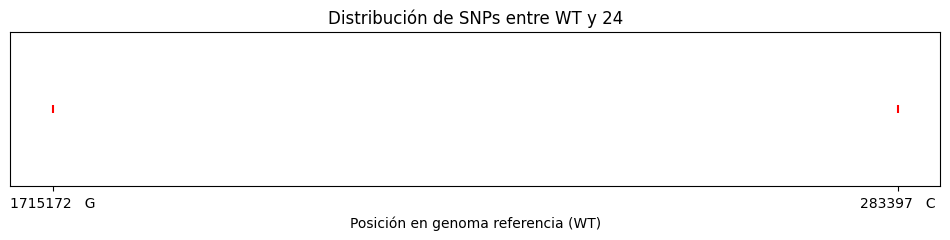

In [28]:
snps_path = 'anotacion/WT_vs_24.snps'

with open(snps_path) as f:
    lines = f.readlines()

# Buscar la línea con '=====' para saber dónde empiezan datos
start_idx = 0
for i, line in enumerate(lines):
    if line.startswith('===='):
        start_idx = i + 1
        break

# Solo líneas con datos
data_lines = lines[start_idx:]

from io import StringIO
snps_str = ''.join(data_lines)

# Columnas típicas del show-snps, anchos aproximados
colspecs = [(0,12), (13,17), (18,25), (26,34), (35,43), (44,51), (52,56), (57, None)]

col_names = ['Ref_pos', 'Ref_base', 'Query_pos', 'Query_base', 'S1', 'S2', 'Type', 'Other']

snps_df = pd.read_fwf(StringIO(snps_str), colspecs=colspecs, names=col_names)

print(f"Número real de SNPs: {snps_df.shape[0]}")
print(snps_df.head())

# Graficar distribución SNPs
import matplotlib.pyplot as plt

plt.figure(figsize=(12,2))
plt.scatter(snps_df['Ref_pos'], [1]*len(snps_df), marker='|', color='red')
plt.xlabel('Posición en genoma referencia (WT)')
plt.title('Distribución de SNPs entre WT y 24')
plt.yticks([])
plt.show()


In [80]:
import pandas as pd

# Carga el archivo gff de Prokka (ajusta ruta)
gff_file = 'anotacion/WT_resultado_prokka/WT_filtrado.gff'

# Leer gff, columnas típicas: seqid, source, type, start, end, score, strand, phase, attributes
gff = pd.read_csv(gff_file, sep='\t', comment='#', header=None,
                  names=['seqid','source','type','start','end','score','strand','phase','attributes'],
                  low_memory=False)

# Filtrar solo genes o CDS
cds = gff[gff['type'].isin(['CDS', 'gene'])].copy()

# Extraer locus_tag o product del campo attributes
def extract_attribute(attr_str, key):
    for field in attr_str.split(';'):
        if field.startswith(key + '='):
            return field.split('=')[1]
    return None

cds['locus_tag'] = cds['attributes'].apply(lambda x: extract_attribute(x, 'locus_tag'))
cds['product'] = cds['attributes'].apply(lambda x: extract_attribute(x, 'product'))

# SNP que quieres buscar
snp_contig = 'NODE_6_length_55188_cov_156.295049'
snp_pos = 18069

# Buscar genes que contienen esa posición
affected = cds[
    (cds['seqid'] == snp_contig) &
    (cds['start'] <= snp_pos) &
    (cds['end'] >= snp_pos)
]

print("Genes afectados por SNP en contig y posición:")
print(affected[['locus_tag','product','start','end']])



Genes afectados por SNP en contig y posición:
Empty DataFrame
Columns: [locus_tag, product, start, end]
Index: []


### Comparación entre 34 y WT

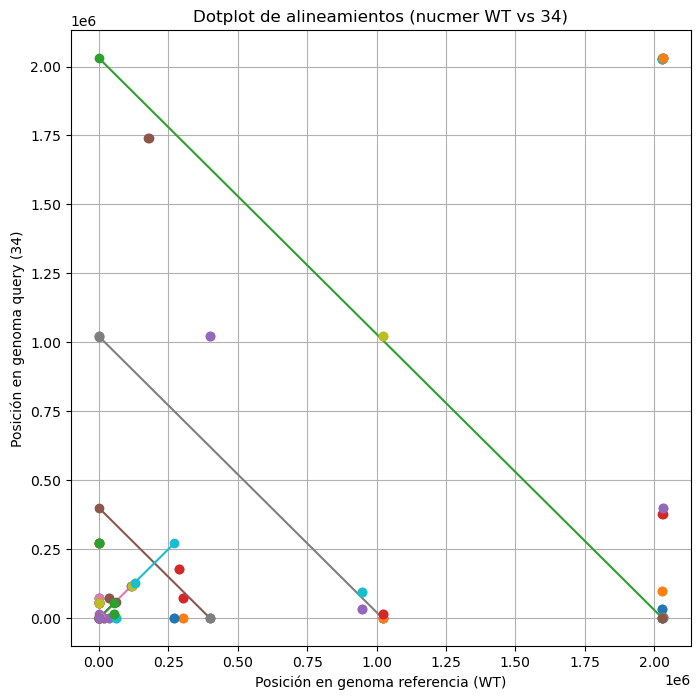

In [3]:
import matplotlib.pyplot as plt
from io import StringIO

# --- Función para parsear archivo .delta y extraer alineamientos ---
def parse_delta(delta_file):
    alignments = []
    with open(delta_file) as f:
        for line in f:
            if line.startswith('>') or line.startswith('#'):
                continue
            line = line.strip()
            if line == '':
                continue
            parts = line.split()
            # Las líneas con 7 números contienen la info de alineamiento
            if len(parts) == 7:
                ref_start, ref_end, query_start, query_end = map(int, parts[0:4])
                alignments.append((ref_start, ref_end, query_start, query_end))
    return alignments


# --- Las rutas a los archivos ---
delta_path = 'anotacion/mummer/WT_vs_34.delta'  # archivo .delta de nucmer


# --- Parsear alineamientos ---
alignments = parse_delta(delta_path)

# --- Plot dotplot simple ---
plt.figure(figsize=(8,8))
for ref_start, ref_end, query_start, query_end in alignments:
    plt.plot([ref_start, ref_end], [query_start, query_end], marker='o')
plt.xlabel('Posición en genoma referencia (WT)')
plt.ylabel('Posición en genoma query (34)')
plt.title('Dotplot de alineamientos (nucmer WT vs 34)')
plt.grid(True)
plt.show()

### Comparación entre 58 y WT

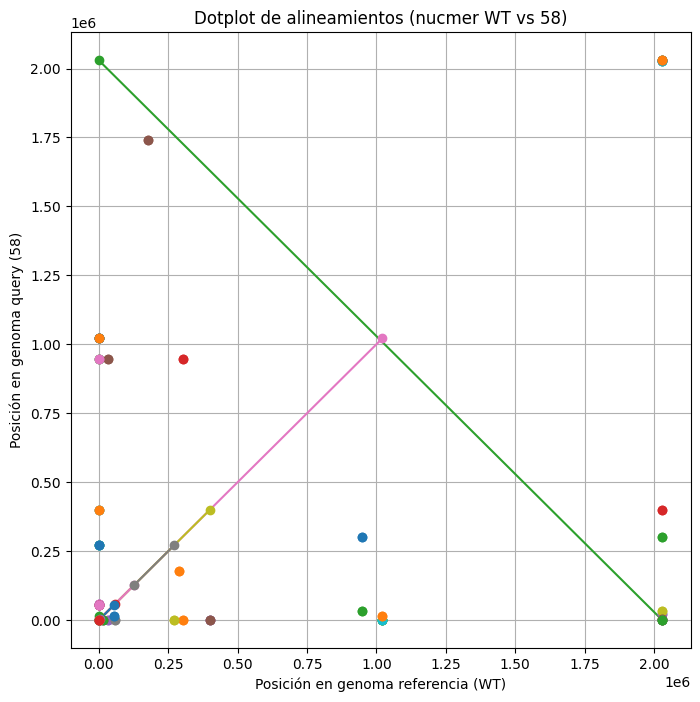

In [51]:
import matplotlib.pyplot as plt
from io import StringIO

# --- Función para parsear archivo .delta y extraer alineamientos ---
def parse_delta(delta_file):
    alignments = []
    with open(delta_file) as f:
        for line in f:
            if line.startswith('>') or line.startswith('#'):
                continue
            line = line.strip()
            if line == '':
                continue
            parts = line.split()
            # Las líneas con 7 números contienen la info de alineamiento
            if len(parts) == 7:
                ref_start, ref_end, query_start, query_end = map(int, parts[0:4])
                alignments.append((ref_start, ref_end, query_start, query_end))
    return alignments


# --- Las rutas a los archivos ---
delta_path = 'anotacion/WT_vs_58.delta'  # archivo .delta de nucmer


# --- Parsear alineamientos ---
alignments = parse_delta(delta_path)

# --- Plot dotplot simple ---
plt.figure(figsize=(8,8))
for ref_start, ref_end, query_start, query_end in alignments:
    plt.plot([ref_start, ref_end], [query_start, query_end], marker='o')
plt.xlabel('Posición en genoma referencia (WT)')
plt.ylabel('Posición en genoma query (58)')
plt.title('Dotplot de alineamientos (nucmer WT vs 58)')
plt.grid(True)
plt.show()

Número real de SNPs: 26
      Ref_pos Ref_base  Query_pos Query_base        S1     S2  Type  \
0  283397   C        T      83397    |   283  97   283  97  |   215   
1  927069   C        T      27069    |    94  82    94  82  |   215   
2  128220   T        G      28220          |   2   128  20  |  2719   
3  128222   A        G      28222          |   2   128  22  |  2719   
4  128225   A        G      28225          |   3   128  25  |  2719   

                                               Other  
0  0  1021550  |  1  1  NODE_2_length_1021550_cov...  
1  0  1021550  |  1  1  NODE_2_length_1021550_cov...  
2  0   271774  |  1  1  NODE_4_length_271960_cov_...  
3  0   271774  |  1  1  NODE_4_length_271960_cov_...  
4  0   271774  |  1  1  NODE_4_length_271960_cov_...  


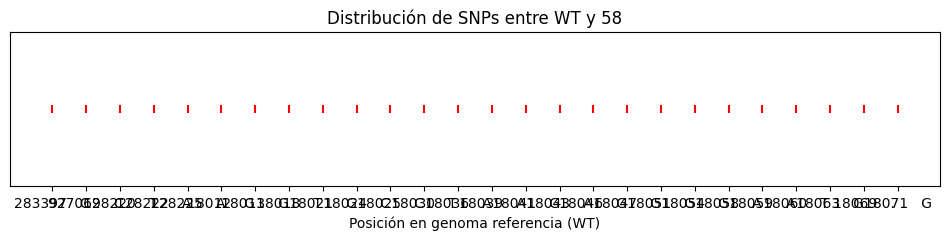

In [55]:
snps_path = 'anotacion/WT_vs_58.snps'

with open(snps_path) as f:
    lines = f.readlines()

# Buscar la línea con '=====' para saber dónde empiezan datos
start_idx = 0
for i, line in enumerate(lines):
    if line.startswith('===='):
        start_idx = i + 1
        break

# Solo líneas con datos
data_lines = lines[start_idx:]

from io import StringIO
snps_str = ''.join(data_lines)

# Columnas típicas del show-snps, anchos aproximados
colspecs = [(0,12), (13,17), (18,25), (26,34), (35,43), (44,51), (52,56), (57, None)]

col_names = ['Ref_pos', 'Ref_base', 'Query_pos', 'Query_base', 'S1', 'S2', 'Type', 'Other']

snps_df = pd.read_fwf(StringIO(snps_str), colspecs=colspecs, names=col_names)

print(f"Número real de SNPs: {snps_df.shape[0]}")
print(snps_df.head())

# Graficar distribución SNPs
import matplotlib.pyplot as plt

plt.figure(figsize=(12,2))
plt.scatter(snps_df['Ref_pos'], [1]*len(snps_df), marker='|', color='red')
plt.xlabel('Posición en genoma referencia (WT)')
plt.title('Distribución de SNPs entre WT y 58')
plt.yticks([])
plt.show()